In [3]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx # For querying OSM using shapefiles
from shapely import intersection
from shapely.ops import unary_union # To combine multiple shapefiles into one

pd.options.display.max_seq_items = 2000
pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_colwidth', 150)

# Two crs, one for coordinates and a projected one to compute areas
crs_geographical = "epsg:4326"
crs_projected = "epsg:28992"


In [6]:
# Load the CBS buurtkaart into a GeoDataFrame
# TODO: We may need some metric for availability of sports venues. Buurtkaart has distance to swimming pools and ice skating rings, but not anything else
path = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/WijkBuurtkaart_2020_v3/buurt_2020_v3.shp'
columns = ["BU_CODE", "BU_NAAM", "GM_NAAM", 
           "P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR',  # Age distribution
           'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT' # Confounders
           ]

gdf = gpd.read_file(path, include_fields=columns)

gdf.loc[gdf["GM_NAAM"] == "\'s-Gravenhage", "GM_NAAM"] = "Den Haag"

# Select the relevant rows
gdf = gdf.query("GM_NAAM=='Amsterdam' or GM_NAAM=='Tilburg' or GM_NAAM=='Den Haag' or GM_NAAM=='Groningen' or GM_NAAM=='Utrecht'")

# Drop missing rows
for name in ["P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR', 'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT']:
    gdf.drop(gdf[gdf[name] < -1000].index, inplace=True)

# Split out the blue and green geometries
gdf_blue = gpd.GeoDataFrame(gdf[["BU_CODE", "BU_NAAM", "GM_NAAM"]].copy())
gdf_blue['geometry'] = np.nan
gdf_blue.set_geometry("geometry")
gdf_blue.set_crs(crs_geographical, inplace=True)

gdf_green = gpd.GeoDataFrame(gdf[["BU_CODE", "BU_NAAM", "GM_NAAM"]].copy())
gdf_green['geometry'] = np.nan
gdf_green.set_geometry("geometry")
gdf_green.set_crs(crs_geographical, inplace=True)

# print(gdf_blue.index.difference(gdf.index))
# print(gdf_green.index.difference(gdf.index))
# print(gdf.index)

# print(gdf.head())
# print(gdf_blue.head())
# print(gdf_green.head())

# Transfrom the buurtkaart to normal coordinates used by normal people
gdf.to_crs(crs_geographical, inplace=True)

# Features that can be considered blue space
blue_features = {
    'natural': 'water'
}

# Features that can be considered green space
green_features = {
    'landuse': 'recreation_ground',
    'landuse': 'village_green',
    'landuse': 'grass',
    'landuse': 'forest', 
    'landuse': 'flowerbed',
    'landuse': 'meadow',
    'leisure': 'garden',
    'leisure': "park",
    'natural': 'tree',
    'natural': 'tree_row',
    'natural': 'scrub',
    'natural': 'wood',
    'natural': 'heath',
    'natural': 'grassland',
    "barrier": 'hedge'
}

# Get water and greenspace for all neighborhoods 
cnt = 0
no_blue_count = 0
no_green_count = 0
for i, row in gdf.iterrows():
    
    print(f"{cnt}/{len(gdf)-1}", end='\r')
    cnt += 1

    try:
        # Get the bluespace for this neighborhood from OSM
        blue = osmnx.features.features_from_polygon(row["geometry"], blue_features)

        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in blue["geometry"]:
            l.append(unit)

        neighborhood_blue = intersection(row["geometry"], unary_union(l))
        # gdf_blue.loc[gdf_blue["BU_CODE"] == row["BU_CODE"], "geometry"] = neighborhood_blue
        # gdf_blue.iloc[i, gdf_blue.columns.get_loc("geometry")] = neighborhood_blue
        gdf_blue.loc[i, "geometry"] = neighborhood_blue

    except osmnx._errors.InsufficientResponseError:
        no_blue_count += 1
    
    try:
        # Get the greenspace for this neighborhood from OSM
        green = osmnx.features.features_from_polygon(row["geometry"], green_features)
       
        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in green["geometry"]:
            l.append(unit)

        neighborhood_green = intersection(row["geometry"], unary_union(l))
        # gdf_green.loc[gdf_green["BU_CODE"] == row["BU_CODE"], "geometry"] = neighborhood_green 
        gdf_green.loc[i, "geometry"] = neighborhood_green

    except osmnx._errors.InsufficientResponseError:
        no_green_count += 1
    
print(f"{no_blue_count} neighborhoods have no bluespace at all")
print(f"{no_green_count} neighborhoods have no greenspace at all")


/tmp/ipykernel_8330/339464290.py:22: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_blue['geometry'] = np.nan
/tmp/ipykernel_8330/339464290.py:27: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_green['geometry'] = np.nan


125 neighborhoods have no bluespace at all
221 neighborhoods have no greenspace at all


In [7]:
# Save and load to not have to do the above over and over again
gdf_blue.to_crs(crs_geographical, inplace=True)
gdf_green.to_crs(crs_geographical, inplace=True)

gdf.to_csv("data/gdf_temp.csv", index=True)
gdf_blue.to_csv("data/gdf_blue_temp.csv", index=True)
gdf_green.to_csv("data/gdf_green_temp.csv", index=True)

In [104]:
# If the above two cells were execute before, they can be skipped by reading the result files instead
gdf = gpd.read_file("data/gdf_temp.csv", 
                    GEOM_POSSIBLE_NAMES="geometry", # Having a column named 'geometry' is too hard for geopandas
                    KEEP_GEOM_COLUMNS="NO").set_index('field_1')
gdf_blue = gpd.read_file("data/gdf_blue_temp.csv", 
                    GEOM_POSSIBLE_NAMES="geometry", # Having a column named 'geometry' is too hard for geopandas
                    KEEP_GEOM_COLUMNS="NO").set_index('field_1')
gdf_green = gpd.read_file("data/gdf_green_temp.csv", 
                    GEOM_POSSIBLE_NAMES="geometry", # Having a column named 'geometry' is too hard for geopandas
                    KEEP_GEOM_COLUMNS="NO").set_index('field_1')

Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

In [105]:
# Set the correct crs
gdf.set_crs(crs_geographical, inplace=True, allow_override=True)
gdf_blue.set_crs(crs_geographical, inplace=True, allow_override=True)
gdf_green.set_crs(crs_geographical, inplace=True, allow_override=True)

# Visualise some information
gdf.info()
gdf.head(5)
gdf.columns

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 899 entries, 149 to 9038
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BU_CODE     899 non-null    object  
 1   BU_NAAM     899 non-null    object  
 2   GM_NAAM     899 non-null    object  
 3   BEV_DICHTH  899 non-null    object  
 4   P_00_14_JR  899 non-null    object  
 5   P_15_24_JR  899 non-null    object  
 6   P_25_44_JR  899 non-null    object  
 7   P_45_64_JR  899 non-null    object  
 8   P_65_EO_JR  899 non-null    object  
 9   P_LAAGINKP  899 non-null    object  
 10  AO_UIT_TOT  899 non-null    object  
 11  WW_UIT_TOT  899 non-null    object  
 12  WWB_UITTOT  899 non-null    object  
 13  geometry    899 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 137.6+ KB


Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

In [106]:
# Visualise the blue- and greenspace

fig, axes = plt.subplots(1, 5, figsize=(25,5))
labels = ["Amsterdam", "Utrecht", "Tilburg", "Groningen", "Den Haag"]
for i in range(5):
    ax = axes[i]
    label = labels[i]
    gdf[gdf["GM_NAAM"] == label].plot(ax=ax, color="grey")
    gdf_blue[gdf_blue["GM_NAAM"] == label].plot(ax=ax, color="blue")
    bounds = gdf[gdf["GM_NAAM"] == label].total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_xlabel("Long")
    ax.set_ylabel("Lat")
    ax.set_title(f"Bluespace in {label}")

fig.tight_layout()
plt.savefig("Bluespace.png", dpi=300)
# plt.show()
plt.clf()

fig, axes = plt.subplots(1, 5, figsize=(25,5))
for i in range(5):
    ax = axes[i]
    label = labels[i]
    gdf[gdf["GM_NAAM"] == label].plot(ax=ax, color="grey")
    gdf_green[gdf_green["GM_NAAM"] == label].plot(ax=ax, color="Green")
    bounds = gdf[gdf["GM_NAAM"] == label].total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_xlabel("Long")
    ax.set_ylabel("Lat")
    ax.set_title(f"Greenspace in {label}")

fig.tight_layout()
plt.savefig("Greenspace.png", dpi=300)
# plt.show()
plt.clf()

Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

<Figure size 2500x500 with 0 Axes>

<Figure size 2500x500 with 0 Axes>

In [107]:
# Transform coordinates to projection with accurate area 
gdf.to_crs(crs_projected, inplace=True)
print(gdf.crs)
gdf_green.to_crs(crs_projected, inplace=True)
print(gdf.crs)
gdf_blue.to_crs(crs_projected, inplace=True)
print(gdf.crs)

print()

print(gdf.head(1)["geometry"])
print(gdf_blue.head(1)["geometry"])
print(gdf_green.head(1)["geometry"])


epsg:28992
epsg:28992
epsg:28992

field_1
149    POLYGON ((233836.217 582380.178, 233892.194 582356.310, 234005.895 582302.135, 234025.630 582289.961, 234048.209 582259.008, 234131.166 582123.210...
Name: geometry, dtype: geometry
field_1
149    POLYGON ((233892.194 582356.310, 234005.895 582302.135, 234025.630 582289.961, 234048.209 582259.008, 234131.166 582123.210, 234188.240 581967.601...
Name: geometry, dtype: geometry
field_1
149    GEOMETRYCOLLECTION (LINESTRING (233912.000 582277.500, 233913.179 582276.930, 233908.948 582268.490, 233911.219 582267.280, 233910.591 582266.090)...
Name: geometry, dtype: geometry


Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

In [108]:
# # Use the geometries to calculate %green and %blue
# def calc_blue(geo, blue_geo):
#     if (blue_geo) is not None:
#         return blue_geo.area / geo.area
#     else:
#         return 0

# def calc_green(geo, green_geo):
#     if (green_geo) is not None:
#         return green_geo.area / geo.area
#     else:
#         return 0

# gdf["percent_blue"] = gdf.apply(lambda row: calc_blue(row["geometry"], row["blue_geometry"]), axis = 1)
# gdf["percent_green"] = gdf.apply(lambda row: calc_green(row["geometry"], row["green_geometry"]), axis = 1)
# gdf.to_crs(crs_geographical, inplace=True)

def calc_area(geo):
    if geo is not None:
        return geo.area
    else:
        return 0

gdf["area"] = gdf.apply(lambda row: calc_area(row["geometry"]), axis=1)
gdf_blue["area"] = gdf_blue.apply(lambda row: calc_area(row["geometry"]), axis=1)
gdf_green["area"] = gdf_green.apply(lambda row: calc_area(row["geometry"]), axis=1)

gdf["percent_blue"] = gdf_blue["area"] / gdf["area"]
gdf["percent_green"] = gdf_green["area"] / gdf["area"]

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 899 entries, 149 to 9038
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   BU_CODE        899 non-null    object  
 1   BU_NAAM        899 non-null    object  
 2   GM_NAAM        899 non-null    object  
 3   BEV_DICHTH     899 non-null    object  
 4   P_00_14_JR     899 non-null    object  
 5   P_15_24_JR     899 non-null    object  
 6   P_25_44_JR     899 non-null    object  
 7   P_45_64_JR     899 non-null    object  
 8   P_65_EO_JR     899 non-null    object  
 9   P_LAAGINKP     899 non-null    object  
 10  AO_UIT_TOT     899 non-null    object  
 11  WW_UIT_TOT     899 non-null    object  
 12  WWB_UITTOT     899 non-null    object  
 13  geometry       899 non-null    geometry
 14  area           899 non-null    float64 
 15  percent_blue   899 non-null    float64 
 16  percent_green  899 non-null    float64 
dtypes: float64(3), geometry(1), o

Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

In [109]:
# Set the geographies back into normal coordinates
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)

epsg:4326
epsg:4326
epsg:4326


Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

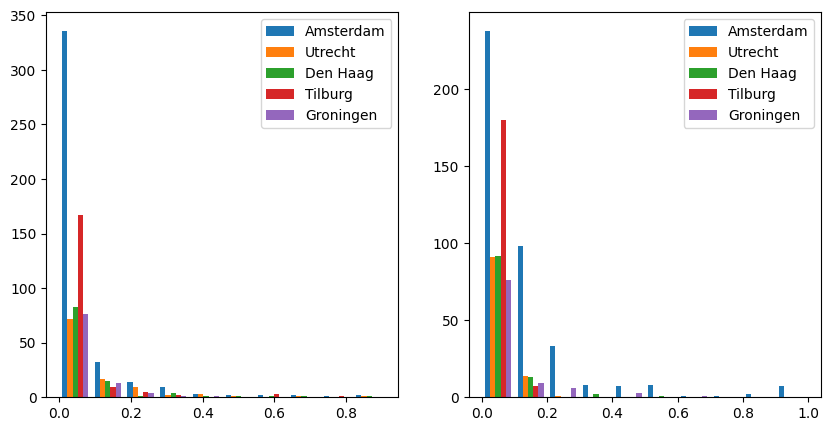

In [118]:
# Visualise the distibution of green- and bluespace
# TODO: Make this look nice
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
labels = ["Amsterdam", "Utrecht", "Den Haag", "Tilburg", "Groningen"]

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_green"])
ax1.hist(to_plot, bins=10, histtype="bar", label=labels)
ax1.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_blue"])
ax2.hist(to_plot, bins=10, histtype="bar", label=labels)
ax2.legend()


plt.show()

In [111]:
# Load Depression risk data fromm buurtatlas
path_buurtatlas = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/data/Gezondheid_per_wijk_en_buurt__2012_2016_2020_2022__indeling_2022__11122023_140527.csv'
df_buurtatlas = pd.read_csv(path_buurtatlas, header=6, delimiter=';')
df_buurtatlas.rename(columns={"Wijken en buurten": "BU_NAAM", "naam": "GM_NAAM", "%": "DEPRESSION_RISK"}, inplace=True)
df_buurtatlas.drop_duplicates(["BU_NAAM", "GM_NAAM"] ,inplace=True)
df_buurtatlas.loc[df_buurtatlas["GM_NAAM"] == "\'s-Gravenhage", "GM_NAAM"] = "Den Haag"
df_buurtatlas.info()

# Rename some buurten so both dataframes understand it
gdf.loc[gdf["BU_NAAM"] == "BelgiÃ«plein e.o.", "BU_NAAM"] = "Belgiëplein e.o."
gdf.loc[gdf["BU_NAAM"] == "Egelantierstraat, MariÃ«ndaalstraat e.o.", "BU_NAAM"] = "Egelantierstraat, Mariëndaalstraat e.o."
gdf.loc[gdf["BU_NAAM"] == "Breedstraat en Plompetorengracht en omgeving", "BU_NAAM"] = "Breedstraat en Plompetorengracht e.o."
gdf.loc[gdf["BU_NAAM"] == "Lange Elisabethstraat, Mariaplaats en omgeving", "BU_NAAM"] = "Lange Elisabethstraat, Mariaplaats e.o."
gdf.loc[gdf["BU_NAAM"] == "MÃ¡ximapark", "BU_NAAM"] = "Máximapark"
gdf.loc[gdf["BU_NAAM"] == "Nieuw Engeland, Th. a. Kempisplantsoen en omgeving", "BU_NAAM"] = "Nieuw Engeland, Th. a. Kempisplantsoen e"
gdf.loc[gdf["BU_NAAM"] == "Zeeheldenbuurt, Hengeveldstraat en omgeving", "BU_NAAM"] = "Zeeheldenbuurt, Hengeveldstraat e.o."

df_buurtatlas.info()
df_buurtatlas.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 1345
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   BU_NAAM          1333 non-null   object
 1   GM_NAAM          1332 non-null   object
 2   DEPRESSION_RISK  1332 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 1345
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   BU_NAAM          1333 non-null   object
 1   GM_NAAM          1332 non-null   object
 2   DEPRESSION_RISK  1332 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB


,BU_NAAM,GM_NAAM,DEPRESSION_RISK
0,Amsterdam,Amsterdam,"9,4"
1,Burgwallen-Oude Zijde,Amsterdam,"8,8"
2,Kop Zeedijk,Amsterdam,"8,2"
3,Oude Kerk e.o.,Amsterdam,"9,4"
4,Burgwallen Oost,Amsterdam,"9,2"


In [112]:
# Compare the names of BuurtAtlas and CBS 
names_cbs = gdf.sort_values("BU_NAAM")["BU_NAAM"].unique()
names_ba = df_buurtatlas.sort_values("BU_NAAM")["BU_NAAM"].unique()

# If this provides no output, every buurt in the gdf has a matching buurtatlas entry
for i in range(len(names_cbs)):
    if names_cbs[i] not in names_ba:
        print(f"{names_cbs[i]} is not found in the buurtatlas names")

In [113]:
# Merge the two dataframes
gdf = gdf.merge(df_buurtatlas, on=["BU_NAAM", "GM_NAAM"], how="left")


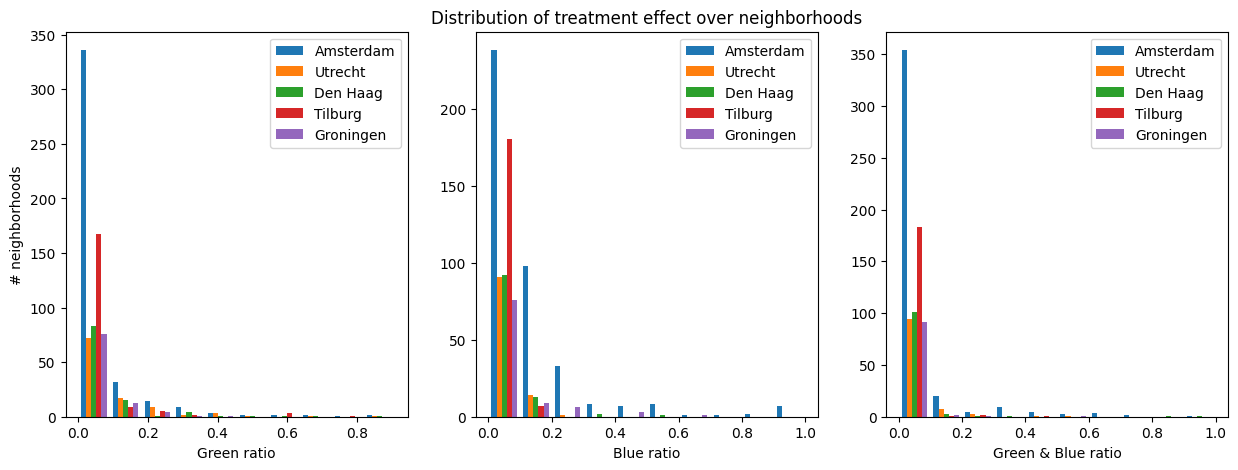

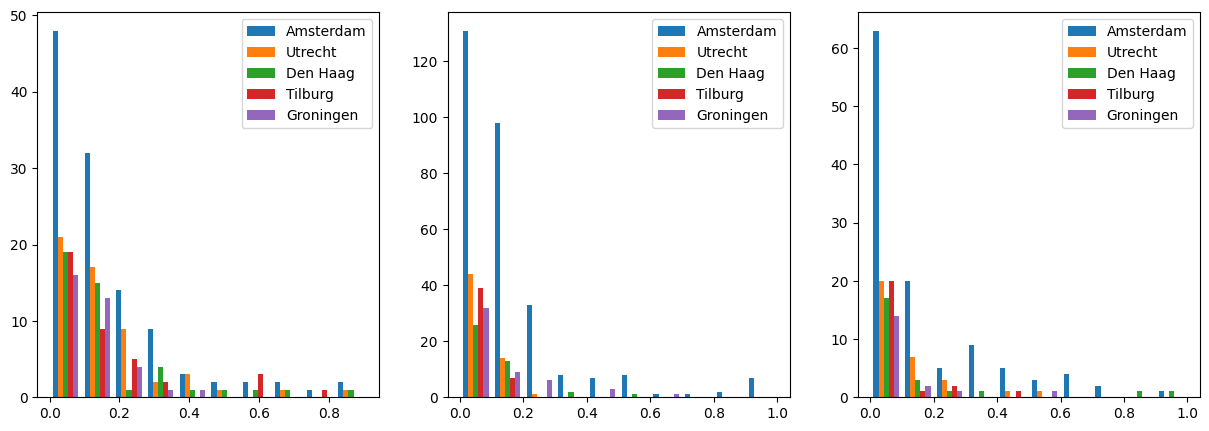

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 288 entries, 8 to 898
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   BU_CODE            288 non-null    object  
 1   BU_NAAM            288 non-null    object  
 2   GM_NAAM            288 non-null    object  
 3   BEV_DICHTH         288 non-null    object  
 4   P_00_14_JR         288 non-null    object  
 5   P_15_24_JR         288 non-null    object  
 6   P_25_44_JR         288 non-null    object  
 7   P_45_64_JR         288 non-null    object  
 8   P_65_EO_JR         288 non-null    object  
 9   P_LAAGINKP         288 non-null    object  
 10  AO_UIT_TOT         288 non-null    object  
 11  WW_UIT_TOT         288 non-null    object  
 12  WWB_UITTOT         288 non-null    object  
 13  geometry           288 non-null    geometry
 14  area               288 non-null    float64 
 15  percent_blue       288 non-null    float64 
 16  

In [137]:
gdf["percent_greenblue"] = gdf["percent_blue"] * gdf["percent_green"]
gdf["percent_greenblue"] = (gdf["percent_greenblue"] - gdf["percent_greenblue"].min()) / (gdf["percent_greenblue"].max() - gdf["percent_greenblue"].min())

nbins = 10

# Visualise the distibution of green- and bluespace
# TODO: Make this look nice
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
labels = ["Amsterdam", "Utrecht", "Den Haag", "Tilburg", "Groningen"]

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_green"])
ax1.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax1.set_ylabel("# neighborhoods")
ax1.set_xlabel("Green ratio")
ax1.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_blue"])
ax2.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax2.set_xlabel("Blue ratio")
ax2.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_greenblue"])
ax3.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax3.set_xlabel("Green & Blue ratio")
ax3.legend()

ax2.set_title("Distribution of treatment effect over neighborhoods")
plt.show()
drop_frac = 0.9

gdf_more_green = gdf.drop(gdf[gdf["percent_green"] < 0.05].sample(frac = drop_frac).index).dropna()
gdf_more_blue = gdf.drop(gdf[gdf["percent_blue"] < 0.05].sample(frac = drop_frac).index).dropna()
gdf_more_greenblue = gdf.drop(gdf[gdf["percent_greenblue"] < 0.05].sample(frac = drop_frac).index).dropna()


# Visualise the distibution of green- and bluespace
# TODO: Make this look nice
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
labels = ["Amsterdam", "Utrecht", "Den Haag", "Tilburg", "Groningen"]

to_plot = []
for label in labels:
    to_plot.append(gdf_more_green[gdf_more_green["GM_NAAM"] == label]["percent_green"])
ax1.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax1.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf_more_blue[gdf_more_blue["GM_NAAM"] == label]["percent_blue"])
ax2.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax2.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf_more_greenblue[gdf_more_greenblue["GM_NAAM"] == label]["percent_greenblue"])
ax3.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax3.legend()

plt.show()

gdf_more_green.info()

In [130]:
gdf = gdf.drop(gdf[gdf["DEPRESSION_RISK"]=="."].index).dropna("index")

# Save the final datasets
gdf_blue.to_csv("data/blue_geometries.csv")
gdf_green.to_csv("data/green_geometries.csv")
gdf.to_csv("data/prepared_data.csv")
gdf_more_green.to_csv("data/prepared_data_more_green.csv")
gdf_more_blue.to_csv("data/prepared_data_more_blue.csv")
gdf_more_greenblue.to_csv("data/prepared_data_more_greenblue.csv")

gdf.info()
gdf["GM_NAAM"].value_counts()

/tmp/ipykernel_8330/1580920428.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  gdf = gdf.drop(gdf[gdf["DEPRESSION_RISK"]=="."].index).dropna("index")


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 899 entries, 0 to 898
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   BU_CODE            899 non-null    object  
 1   BU_NAAM            899 non-null    object  
 2   GM_NAAM            899 non-null    object  
 3   BEV_DICHTH         899 non-null    object  
 4   P_00_14_JR         899 non-null    object  
 5   P_15_24_JR         899 non-null    object  
 6   P_25_44_JR         899 non-null    object  
 7   P_45_64_JR         899 non-null    object  
 8   P_65_EO_JR         899 non-null    object  
 9   P_LAAGINKP         899 non-null    object  
 10  AO_UIT_TOT         899 non-null    object  
 11  WW_UIT_TOT         899 non-null    object  
 12  WWB_UITTOT         899 non-null    object  
 13  geometry           899 non-null    geometry
 14  area               899 non-null    float64 
 15  percent_blue       899 non-null    float64 
 16  

Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

TypeError: Legend.__init__() got an unexpected keyword argument 'label'

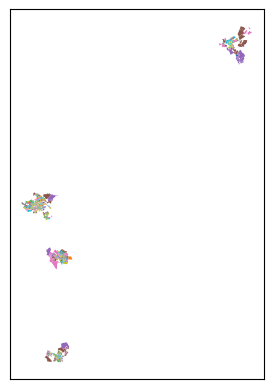

In [59]:
fig, ax = plt.subplots(1,1)

# This gets rid of the ticks (they're wrong :( )
plt.setp(ax.get_yticklabels(), visible=False)
ax.yaxis.set_tick_params(size=0)
plt.setp(ax.get_xticklabels(), visible=False)
ax.xaxis.set_tick_params(size=0)


gdf.to_crs(crs_geographical, inplace=True)


gdf.plot(ax=ax, 
         column="DEPRESSION_RISK", 
         legend=True,
         legend_kwds={"label": "Risk (%)", "orientation": "horizontal"}
         )

ax.set_xlabel("Long")
ax.set_ylabel("Lat")
ax.set_title("Depression risk in Amsterdam")

fig.tight_layout()
plt.savefig("Depression_amsterdam.png", dpi=300)
plt.clf()